In [ ]:
!pip install transformers==4.14.1
!pip install bitsandbytes-cuda111
!pip install datasets==1.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 66.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=78c66fb8dbac54ffd9c7324389d67fcc9f28480597d3fef3c6cd0f99c9f7b9ad
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 6.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.

In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [ ]:
!git clone https://github.com/feralvam/easse.git


Cloning into 'easse'...
remote: Enumerating objects: 1960, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 1960 (delta 107), reused 95 (delta 95), pack-reused 1827
Receiving objects: 100% (1960/1960), 33.14 MiB | 17.33 MiB/s, done.
Resolving deltas: 100% (1229/1229), done.


In [ ]:
%cd content
%cd easse


[Errno 2] No such file or directory: 'content'
/content
/content/easse


In [ ]:
!ls
!pip install -e .

demo   example.sh  MANIFEST.in	requirements.txt  setup.py
easse  LICENSE	   README.md	setup.cfg	  tests
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/easse
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/text-simplification-evaluation.git (to revision main) to /tmp/pip-install-sa26n67s/tseval_4fe22d64bc4c41d5bcfd573b7a9d097d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/text-simplification-evaluation.git /tmp/pip-install-sa26n67s/tseval_4fe22d64bc4c41d5bcfd573b7a9d097d
  Resolved https://github.com/facebookresearch/text-simplification-evaluation.git to commit f335e2e27026321c7c3d1dd63857416c7e7397b2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 480.8 kB/s eta 0:00:00
  Preparing metadata (setup

In [ ]:
import transformers
from easse.sari import corpus_sari
from easse.bleu import corpus_bleu
import torch
import torch.nn.functional as F
from torch import nn
from torch.cuda.amp import custom_fwd, custom_bwd
from bitsandbytes.functional import quantize_blockwise, dequantize_blockwise
from tqdm.auto import tqdm
import pandas as pd
from google.colab import files


==============================WARNING: DEPRECATED!==============================
WARNING! This version of bitsandbytes is deprecated. Please switch to `pip install bitsandbytes` and the new repo: https://github.com/TimDettmers/bitsandbytes
==============================WARNING: DEPRECATED!==============================


### Converting the model to 8 bits.

We convert EleutherAI's GPT-J-6B model to 8 bits using facebook's [bitsandbytes](https://github.com/facebookresearch/bitsandbytes) library. This reduces the model's size from 20Gb down to just 6Gb.

Note that we don't convert linear layer biases to 8 bit as they take up less that 1% of the model's weight anyway.

In [ ]:

class FrozenBNBLinear(nn.Module):
    def __init__(self, weight, absmax, code, bias=None):
        assert isinstance(bias, nn.Parameter) or bias is None
        super().__init__()
        self.out_features, self.in_features = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
        self.bias = bias
 
    def forward(self, input):
        output = DequantizeAndLinear.apply(input, self.weight, self.absmax, self.code, self.bias)
        if self.adapter:
            output += self.adapter(input)
        return output
 
    @classmethod
    def from_linear(cls, linear: nn.Linear) -> "FrozenBNBLinear":
        weights_int8, state = quantize_blockise_lowmemory(linear.weight)
        return cls(weights_int8, *state, linear.bias)
 
    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"
 
 
class DequantizeAndLinear(torch.autograd.Function): 
    @staticmethod
    @custom_fwd
    def forward(ctx, input: torch.Tensor, weights_quantized: torch.ByteTensor,
                absmax: torch.FloatTensor, code: torch.FloatTensor, bias: torch.FloatTensor):
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        ctx.save_for_backward(input, weights_quantized, absmax, code)
        ctx._has_bias = bias is not None
        return F.linear(input, weights_deq, bias)
 
    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output: torch.Tensor):
        assert not ctx.needs_input_grad[1] and not ctx.needs_input_grad[2] and not ctx.needs_input_grad[3]
        input, weights_quantized, absmax, code = ctx.saved_tensors
        # grad_output: [*batch, out_features]
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        grad_input = grad_output @ weights_deq
        grad_bias = grad_output.flatten(0, -2).sum(dim=0) if ctx._has_bias else None
        return grad_input, None, None, None, grad_bias
 
 
class FrozenBNBEmbedding(nn.Module):
    def __init__(self, weight, absmax, code):
        super().__init__()
        self.num_embeddings, self.embedding_dim = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.adapter = None
 
    def forward(self, input, **kwargs):
        with torch.no_grad():
            # note: both quantuized weights and input indices are *not* differentiable
            weight_deq = dequantize_blockwise(self.weight, absmax=self.absmax, code=self.code)
            output = F.embedding(input, weight_deq, **kwargs)
        if self.adapter:
            output += self.adapter(input)
        return output 
 
    @classmethod
    def from_embedding(cls, embedding: nn.Embedding) -> "FrozenBNBEmbedding":
        weights_int8, state = quantize_blockise_lowmemory(embedding.weight)
        return cls(weights_int8, *state)
 
    def __repr__(self):
        return f"{self.__class__.__name__}({self.num_embeddings}, {self.embedding_dim})"
 
 
def quantize_blockise_lowmemory(matrix: torch.Tensor, chunk_size: int = 2 ** 20):
    assert chunk_size % 4096 == 0
    code = None
    chunks = []
    absmaxes = []
    flat_tensor = matrix.view(-1)
    for i in range((matrix.numel() - 1) // chunk_size + 1):
        input_chunk = flat_tensor[i * chunk_size: (i + 1) * chunk_size].clone()
        quantized_chunk, (absmax_chunk, code) = quantize_blockwise(input_chunk, code=code)
        chunks.append(quantized_chunk)
        absmaxes.append(absmax_chunk)
 
    matrix_i8 = torch.cat(chunks).reshape_as(matrix)
    absmax = torch.cat(absmaxes)
    return matrix_i8, (absmax, code)
 
 
def convert_to_int8(model):
    """Convert linear and embedding modules to 8-bit with optional adapters"""
    for module in list(model.modules()):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                print(name, child)
                setattr( 
                    module,
                    name,
                    FrozenBNBLinear(
                        weight=torch.zeros(child.out_features, child.in_features, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                        bias=child.bias,
                    ),
                )
            elif isinstance(child, nn.Embedding):
                setattr(
                    module,
                    name,
                    FrozenBNBEmbedding(
                        weight=torch.zeros(child.num_embeddings, child.embedding_dim, dtype=torch.uint8),
                        absmax=torch.zeros((child.weight.numel() - 1) // 4096 + 1),
                        code=torch.zeros(256),
                    )
                )

In [ ]:
class GPTJBlock(transformers.models.gptj.modeling_gptj.GPTJBlock):
    def __init__(self, config):
        super().__init__(config)

        convert_to_int8(self.attn)
        convert_to_int8(self.mlp)


class GPTJModel(transformers.models.gptj.modeling_gptj.GPTJModel):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)
        

class GPTJForCausalLM(transformers.models.gptj.modeling_gptj.GPTJForCausalLM):
    def __init__(self, config):
        super().__init__(config)
        convert_to_int8(self)


transformers.models.gptj.modeling_gptj.GPTJBlock = GPTJBlock  # monkey-patch GPT-J

In [ ]:
config = transformers.GPTJConfig.from_pretrained("EleutherAI/gpt-j-6B")
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

Downloading:   0%|          | 0.00/930 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
gpt = GPTJForCausalLM.from_pretrained("hivemind/gpt-j-6B-8bit", low_cpu_mem_usage=True)

device = 'cuda' 
# if torch.cuda.is_available(): else:  device =  'cpu'
#     gpt.to(device)

gpt.to(device)


Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.75G [00:00<?, ?B/s]

k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, 

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpt.to(device)

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0

## Text generation example





In [ ]:
prompt = tokenizer("A cat sat on a mat", return_tensors='pt')
prompt = {key: value.to(device) for key, value in prompt.items()}
out = gpt.generate(**prompt, min_length=128, max_length=128, do_sample=True)
tokenizer.decode(out[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'A cat sat on a mat in the sun, gazing absently at three kittens, who were lying on their sides, one on top of the other, their tiny eyes blinking like little lights and their tails twitching from side to side.\n\nOn the other side of the clearing, a few metres away, stood an old man in his old clothes.\n\nHe looked round.\n\nThere was no one else nearby. A few hundred metres up, on the other side of a narrow stream, was a large tent. A few animals were browsing in the long yellow grass beyond the stream and in the forest at the other side'

## Train on wiki to simplifay 

In [ ]:
%cd ..
%cd ..
%cd content

/content
/
/content


In [ ]:
!ls

easse  sample_data


In [ ]:
wiki = pd.read_csv(r'wiki_to_fine_f.csv')

In [ ]:
wiki_train, wiki_test = wiki[:len(wiki['text'])-100], wiki[len(wiki['text'])-100:]

In [ ]:
wiki

,text
0,simplify the text: \n text: Hofstetten-Fl ֳ¼h ...
1,simplify the text: \n text: It rapidly intensi...
2,simplify the text: \n text: Thomas Eastoe Abbo...
3,simplify the text: \n text: The SAT Reasoning ...
4,simplify the text: \n text: It is claimed that...
...,...
8073,simplify the text: \n text: Although the WHA w...
8074,simplify the text: \n text: The identity of th...
8075,simplify the text: \n text: The Jekyll & Hyde ...
8076,simplify the text: \n text: Ursula Kroeber Le ...


In [ ]:
from bitsandbytes.optim import Adam8bit

gpt.gradient_checkpointing_enable()
losses = []
optimizer = Adam8bit(gpt.parameters(), lr=1e-5)
count = 0 

with torch.cuda.amp.autocast():
    for row in tqdm(wiki_train["text"]):
        count += 1
        if len(row) <= 1:
            continue

        batch = tokenizer(row, truncation=True, max_length=128, return_tensors='pt')
        batch = {k: v.cuda() for k, v in batch.items()}

        out = gpt.forward(**batch,)

        loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                               reduction='mean')
        print(loss)
        print(count ,'/', len(wiki_train['text']))
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/8078 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
tensor(1.0564, device='cuda:0', grad_fn=<NllLossBackward0>)
5579 / 8078
tensor(1.0131, device='cuda:0', grad_fn=<NllLossBackward0>)
5580 / 8078
tensor(1.0618, device='cuda:0', grad_fn=<NllLossBackward0>)
5581 / 8078
tensor(1.1689, device='cuda:0', grad_fn=<NllLossBackward0>)
5582 / 8078
tensor(1.7792, device='cuda:0', grad_fn=<NllLossBackward0>)
5583 / 8078
tensor(1.6523, device='cuda:0', grad_fn=<NllLossBackward0>)
5584 / 8078
tensor(0.6382, device='cuda:0', grad_fn=<NllLossBackward0>)
5585 / 8078
tensor(1.7815, device='cuda:0', grad_fn=<NllLossBackward0>)
5586 / 8078
tensor(1.1677, device='cuda:0', grad_fn=<NllLossBackward0>)
5587 / 8078
tensor(1.9170, device='cuda:0', grad_fn=<NllLossBackward0>)
5588 / 8078
tensor(1.4594, device='cuda:0', grad_fn=<NllLossBackward0>)
5589 / 8078
tensor(1.4166, device='cuda:0', grad_fn=<NllLossBackward0>)
5590 / 8078
tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward0>)
5591 / 8078
tensor(1.8352

In [ ]:
import matplotlib.pyplot as plt



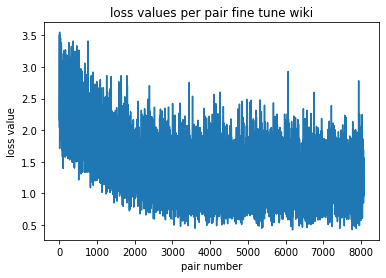

In [ ]:
plt.plot(range(len(losses)),losses)
plt.title('loss values per pair fine tune wiki')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

#Train advance to intermediate

In [ ]:
df_a_t_i = pd.read_csv(r'ADV-INT.csv')

In [ ]:
df_a_t_i

,text
0,simplify the text to Intermediate: \n text: Br...
1,simplify the text to Intermediate: \n text: Un...
2,simplify the text to Intermediate: \n text: Bu...
3,simplify the text to Intermediate: \n text: Am...
4,simplify the text to Intermediate: \n text: Al...
...,...
2149,simplify the text to Intermediate: \n text: Wo...
2150,simplify the text to Intermediate: \n text: We...
2151,simplify the text to Intermediate: \n text: Ou...
2152,simplify the text to Intermediate: \n text: Th...


In [ ]:
df_a_t_i_train, df_a_t_i_test = df_a_t_i[:len(df_a_t_i['text'])-100], df_a_t_i[len(df_a_t_i['text'])-100:]

In [ ]:
from bitsandbytes.optim import Adam8bit

gpt.gradient_checkpointing_enable()

optimizer = Adam8bit(gpt.parameters(), lr=1e-5)
losses2 = []
count = 0 
with torch.cuda.amp.autocast():
    for row in tqdm(df_a_t_i_train["text"]):
        if len(row) <= 1:
            continue
        count = count +1

        batch = tokenizer(row, truncation=True, max_length=128, return_tensors='pt')
        batch = {k: v.cuda() for k, v in batch.items()}

        out = gpt.forward(**batch,)

        loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                               reduction='mean')
        print(loss)
        print(count ,'/', len(df_a_t_i_train['text']))
        loss.backward()
        losses2.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/2054 [00:00<?, ?it/s]

tensor(2.8105, device='cuda:0', grad_fn=<NllLossBackward0>)
1 / 2054
tensor(3.0845, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 2054
tensor(2.5822, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 2054
tensor(3.0718, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 2054
tensor(2.6578, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 2054
tensor(2.5255, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 2054
tensor(3.0639, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 2054
tensor(3.8041, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 2054
tensor(2.9102, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 2054
tensor(3.2692, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 2054
tensor(3.9198, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 2054
tensor(3.0480, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 2054
tensor(2.7307, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 2054
tensor(3.6152, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 2054
tensor(3.1049, device='cuda:0

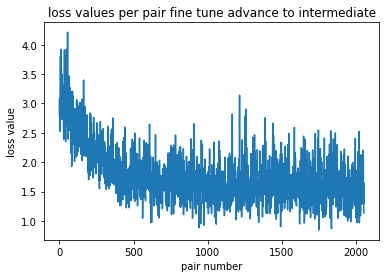

In [ ]:
plt.plot(range(len(losses2)),losses2)
plt.title('loss values per pair fine tune advance to intermediate')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

# Train intermediate to elementary

In [ ]:
df_i_t_e = pd.read_csv(r'INT-ELE.csv')

In [ ]:
df_i_t_e

,text
0,simplify the text to elementary: \n text: The ...
1,simplify the text to elementary: \n text: Allo...
2,simplify the text to elementary: \n text: Arge...
3,simplify the text to elementary: \n text: The ...
4,simplify the text to elementary: \n text: The ...
...,...
1669,simplify the text to elementary: \n text: Dave...
1670,simplify the text to elementary: \n text: Work...
1671,simplify the text to elementary: \n text: The ...
1672,simplify the text to elementary: \n text: Whil...


In [ ]:
df_i_t_e_train, df_i_t_e_test = df_i_t_e[:len(df_i_t_e['text'])-100], df_i_t_e[len(df_i_t_e['text'])-100:]

In [ ]:
from bitsandbytes.optim import Adam8bit

gpt.gradient_checkpointing_enable()

optimizer = Adam8bit(gpt.parameters(), lr=1e-5)
count = 0 
losses3 = []
with torch.cuda.amp.autocast():
    for row in tqdm(df_i_t_e_train["text"]):
        if len(row) <= 1:
            continue
        count = count +1
        batch = tokenizer(row, truncation=True, max_length=128, return_tensors='pt')
        batch = {k: v.cuda() for k, v in batch.items()}

        out = gpt.forward(**batch,)

        loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                               reduction='mean')
        print(loss)
        print(count ,'/', len(df_i_t_e_train['text']))
        loss.backward()
        losses3.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1574 [00:00<?, ?it/s]

tensor(2.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
1 / 1574
tensor(1.6340, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 1574
tensor(2.2254, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 1574
tensor(1.8265, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 1574
tensor(1.8000, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 1574
tensor(2.0772, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 1574
tensor(2.0058, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 1574
tensor(2.1516, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 1574
tensor(1.9369, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 1574
tensor(1.8583, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 1574
tensor(2.1645, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 1574
tensor(1.9250, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 1574
tensor(1.8377, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 1574
tensor(1.8857, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 1574
tensor(1.8875, device='cuda:0

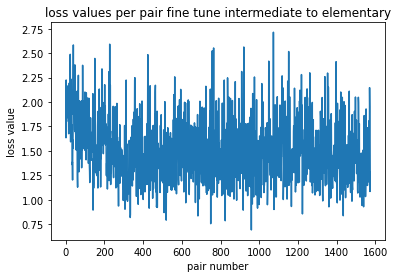

In [ ]:
plt.plot(range(len(losses3)),losses3)
plt.title('loss values per pair fine tune intermediate to elementary')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

#Train on Newsela data

#Train advance to intermediate

In [ ]:
newsela_a_to_i = pd.read_csv(r'df_newSela_fine_tune_ad_int.csv')

In [ ]:
newsela_a_to_i_train, newsela_a_to_i_test = newsela_a_to_i[:len(newsela_a_to_i['text'])-100],newsela_a_to_i[len(newsela_a_to_i['text'])-100:]

In [ ]:
from bitsandbytes.optim import Adam8bit

gpt.gradient_checkpointing_enable()

optimizer = Adam8bit(gpt.parameters(), lr=1e-5)
count = 0 
losses4 = []
with torch.cuda.amp.autocast():
    for row in tqdm(newsela_a_to_i_train["text"]):
        if len(row) <= 1:
            continue
        count = count +1
        batch = tokenizer(row, truncation=True, max_length=128, return_tensors='pt')
        batch = {k: v.cuda() for k, v in batch.items()}

        out = gpt.forward(**batch,)

        loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                               reduction='mean')
        print(loss)
        print(count ,'/', len(newsela_a_to_i_train['text']))
        loss.backward()
        losses4.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/3482 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
tensor(1.5036, device='cuda:0', grad_fn=<NllLossBackward0>)
983 / 3482
tensor(1.3898, device='cuda:0', grad_fn=<NllLossBackward0>)
984 / 3482
tensor(1.4350, device='cuda:0', grad_fn=<NllLossBackward0>)
985 / 3482
tensor(1.6742, device='cuda:0', grad_fn=<NllLossBackward0>)
986 / 3482
tensor(1.6884, device='cuda:0', grad_fn=<NllLossBackward0>)
987 / 3482
tensor(1.5426, device='cuda:0', grad_fn=<NllLossBackward0>)
988 / 3482
tensor(1.6823, device='cuda:0', grad_fn=<NllLossBackward0>)
989 / 3482
tensor(1.4294, device='cuda:0', grad_fn=<NllLossBackward0>)
990 / 3482
tensor(1.8436, device='cuda:0', grad_fn=<NllLossBackward0>)
991 / 3482
tensor(1.5910, device='cuda:0', grad_fn=<NllLossBackward0>)
992 / 3482
tensor(1.8141, device='cuda:0', grad_fn=<NllLossBackward0>)
993 / 3482
tensor(2.0336, device='cuda:0', grad_fn=<NllLossBackward0>)
994 / 3482
tensor(1.1300, device='cuda:0', grad_fn=<NllLossBackward0>)
995 / 3482
tensor(1.3737, device='cud

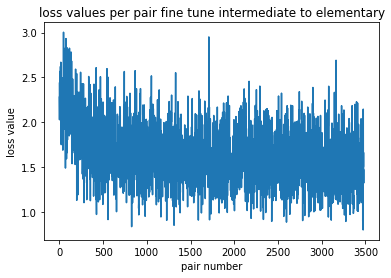

In [ ]:
plt.plot(range(len(losses4)),losses4)
plt.title('loss values per pair fine tune intermediate to elementary')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

# Train intermediate to elementary

In [ ]:
newsela_i_to_e = pd.read_csv(r'df_newSela_fine_tune_int_el.csv')

In [ ]:
newsela_a_to_i_train, newsela_a_to_i_test = newsela_i_to_e[:len(newsela_i_to_e['text'])-100],newsela_i_to_e[len(newsela_i_to_e['text'])-100:]

In [ ]:
from bitsandbytes.optim import Adam8bit

gpt.gradient_checkpointing_enable()

optimizer = Adam8bit(gpt.parameters(), lr=1e-5)
count = 0 
losses5 = []
with torch.cuda.amp.autocast():
    for row in tqdm(newsela_a_to_i_train["text"]):
        if len(row) <= 1:
            continue
        count = count +1
        batch = tokenizer(row, truncation=True, max_length=128, return_tensors='pt')
        batch = {k: v.cuda() for k, v in batch.items()}

        out = gpt.forward(**batch,)

        loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(),
                               reduction='mean')
        print(loss)
        print(count ,'/', len(newsela_a_to_i_train['text']))
        loss.backward()
        losses5.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1534 [00:00<?, ?it/s]

tensor(1.7208, device='cuda:0', grad_fn=<NllLossBackward0>)
1 / 1534
tensor(2.8427, device='cuda:0', grad_fn=<NllLossBackward0>)
2 / 1534
tensor(2.1816, device='cuda:0', grad_fn=<NllLossBackward0>)
3 / 1534
tensor(1.4754, device='cuda:0', grad_fn=<NllLossBackward0>)
4 / 1534
tensor(1.9540, device='cuda:0', grad_fn=<NllLossBackward0>)
5 / 1534
tensor(1.9563, device='cuda:0', grad_fn=<NllLossBackward0>)
6 / 1534
tensor(2.0413, device='cuda:0', grad_fn=<NllLossBackward0>)
7 / 1534
tensor(1.6838, device='cuda:0', grad_fn=<NllLossBackward0>)
8 / 1534
tensor(1.8916, device='cuda:0', grad_fn=<NllLossBackward0>)
9 / 1534
tensor(1.6937, device='cuda:0', grad_fn=<NllLossBackward0>)
10 / 1534
tensor(2.0826, device='cuda:0', grad_fn=<NllLossBackward0>)
11 / 1534
tensor(2.1382, device='cuda:0', grad_fn=<NllLossBackward0>)
12 / 1534
tensor(1.4914, device='cuda:0', grad_fn=<NllLossBackward0>)
13 / 1534
tensor(1.8640, device='cuda:0', grad_fn=<NllLossBackward0>)
14 / 1534
tensor(1.6785, device='cuda:0

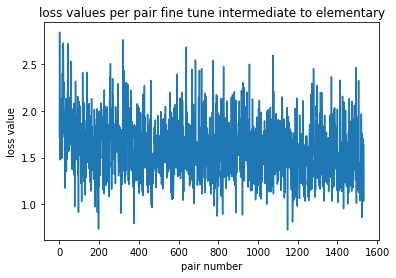

In [ ]:
plt.plot(range(len(losses5)),losses5)
plt.title('loss values per pair fine tune intermediate to elementary')
plt.xlabel('pair number')
plt.ylabel('loss value')
plt.show()

Saving the wights 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
torch.save(gpt.state_dict(), 'gdrive/MyDrive/Final Project Data/model_tensor_all.pt')

Mounted at /content/gdrive


## loading the wights for testing 

In [ ]:
gpt.load_state_dict( torch.load('gdrive/MyDrive/Final Project Data/model_tensor_all.pt'))

###Text simplification try

In [ ]:
prompt = tokenizer("simplify the text: n/ text: When you see the word Amazon, whats the first thing that springs to mind  the worlds biggest forest, the longest river or the largest internet retailer  and which do you consider most important? to:", return_tensors='pt')
prompt = {key: value.to(device) for key, value in prompt.items()}
out = gpt.generate(**prompt, min_length=128, max_length=128, do_sample=True)
tokenizer.decode(out[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'simplify the text: n/ text: When you see the word Amazon, what\x92s the first thing that springs to mind \x96 the world\x92s biggest forest, the longest river or the largest internet retailer \x96 and which do you consider most important? to: The " Amazon " in the question is the city of Manaus, in the Brazilian state of Amazonas, and the word Amazon can also be a reminder that you are going to a forest-covered river valley in a country that gets 70 percent of its electricity from hydro power. to: The " Amazon " in the question is Manaus, which'

#run model from advance to intermediate on train set




##run model on wiki files

In [ ]:
orig_sents_i = []
sys_sents_i_t_e = []

In [ ]:
for i in range(100):
  print(orig_sents_i[i])
  print('___')
  print(sys_sents_a_t_e[i])
  print('___end')
